In [1]:
from easyocr.easyocr import Reader
model = Reader(
    lang_list=['pt'],
    gpu=False,
    model_storage_directory='backend/ai-models',
    user_network_directory='backend/ai-models',
)

Using CPU. Note: This module is much faster with a GPU.


In [58]:
import cv2 as cv
import numpy as np
import skimage.io as skio
import matplotlib.pyplot as plt

In [67]:
from typing import Callable
class pipeline:
    __slots__ = 'steps', 'results', 'model'
    def __init__(self, steps: list[Callable[[np.ndarray], np.ndarray]]) -> None:
        self.steps = steps
        self.results = []
    
    def using(self, model):
        self.model = model
        return self

    def process(self, image):
        result = image
        for func in self.steps:
            result = func(result)
            self.results.append(result)
        return self
    
    def draw_predictions(self, image: np.ndarray, preds, verbose=True) -> np.ndarray:
        if not preds:
            return image
        image = image.copy()
        bboxes, texts, probs = list(zip(*preds))
        bboxes = np.array(bboxes)[:, [0, 2]].astype(int)

        match image.shape[-1]:
            case 4: color = (0, 255, 0, 255)
            case 3: color = (0, 255, 0)
            case _: color = (100,)

        for i, [(top_left, bottom_right), text, prob] in enumerate(zip(bboxes, texts, probs), start=1):
            if verbose:
                print(f"({i}) {prob:.0%}: {text}")
            cv.rectangle(image, top_left, bottom_right, color, 1)
            top_left += (-10, 10)
            cv.putText(image, str(i), top_left, cv.FONT_HERSHEY_DUPLEX, 0.5, color, 1)
        return image

    def predict(self, image=None):
        if image is None:
            image = self.results[-1]
        preds = self.model.readtext(image)
        result = self.draw_predictions(image, preds)
        self.results.append(result)
        return self

    def display(self):
        image = np.concatenate(self.results, axis=1)
        skio.imshow(image)

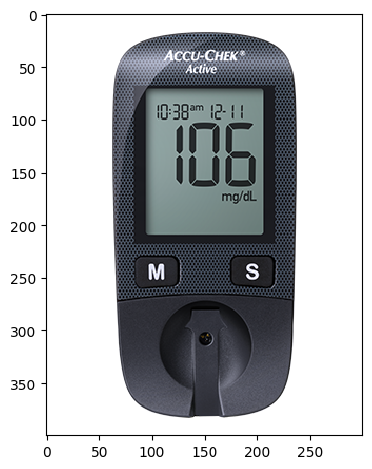

In [197]:
image = skio.imread('.vscode/image.png')
image_gray = cv.cvtColor(image, cv.COLOR_RGBA2GRAY)
skio.imshow(image);

(1) 84%: 106


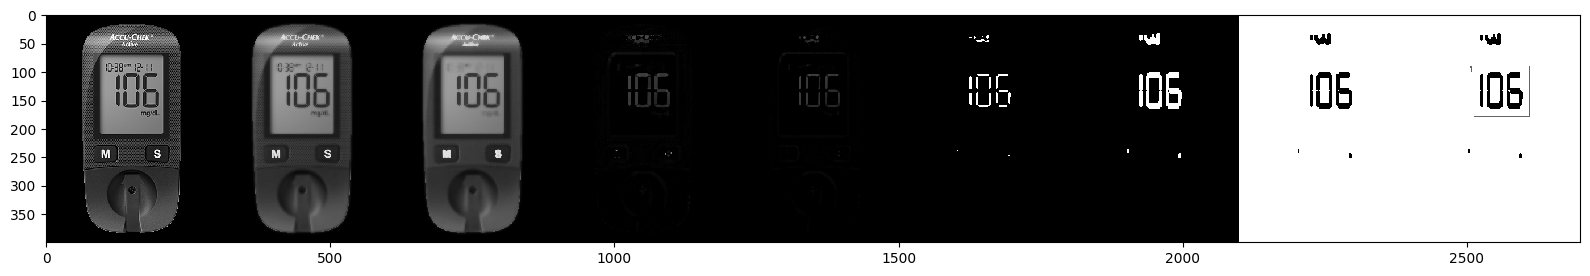

In [225]:
processed = pipeline([
    lambda x: x,
    lambda x: cv.bilateralFilter(x, 9, 75, 75),
    lambda x: cv.morphologyEx(x, cv.MORPH_CLOSE, cv.getStructuringElement(cv.MORPH_ELLIPSE, (5,5))),
    lambda x: cv.morphologyEx(x, cv.MORPH_BLACKHAT, cv.getStructuringElement(cv.MORPH_RECT, (7,7))),
    lambda x: cv.morphologyEx(x, cv.MORPH_ERODE, cv.getStructuringElement(cv.MORPH_ELLIPSE, (3,3))),
    lambda x: cv.threshold(x, 30, 255, 0)[1],
    lambda x: cv.morphologyEx(x, cv.MORPH_DILATE, cv.getStructuringElement(cv.MORPH_ELLIPSE, (3,8))),
    lambda x: 255 - x,
])
plt.figure(figsize=(16, 12))
# processed.using(model).process(image_gray).display()
processed.using(model).process(image_gray).predict().display();

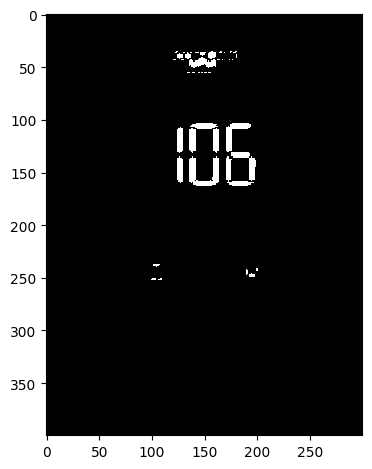

In [190]:
ret, thresh = cv.threshold(processed.results[3], 30, 255, 0)
contours, hierarchy = cv.findContours(thresh, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)
skio.imshow(thresh)

In [130]:
cv.cvtColor(processed, cv.COLOR_GRAY2BGRA).shape

(400, 300, 4)

In [230]:
a = cv.imencode('.jpg', image)[1].tobytes()

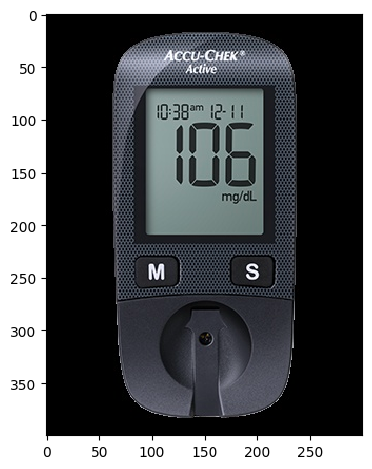

In [239]:
im = cv.imdecode(np.frombuffer(a, np.uint8), cv.IMREAD_UNCHANGED)
skio.imshow(im);

(400, 300)


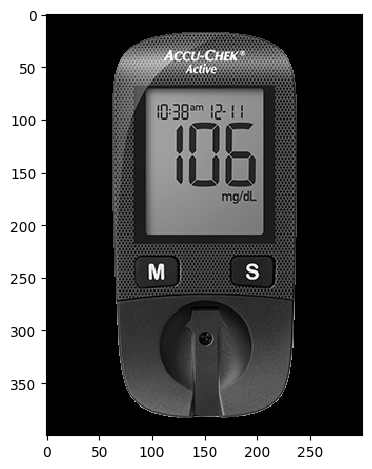

In [242]:
im = cv.imdecode(np.frombuffer(a, np.uint8), cv.IMREAD_GRAYSCALE)
print(im.shape)
skio.imshow(im);